In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2023-06-20 20:27:39.002405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 20:27:39.564051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/TrkAna/lib:/mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/Production/lib:/mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/Offline/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cryptopp/v08_02_00/Linux64bit+3.10-2.17-e20-prof:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib64:/cvmfs/mu2e.op

In [3]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#filelist = os.environ['KKTrainBkgFiles']
filelist = "KKTrainBkgFiles.txt"
print("Using files in " + filelist)
files = open(filelist, 'r')
for filename in files:
    print("Processing: " + filename)    
    with uproot.open(filename) as file:
        bkgdiag = file["BD"]["bkgcdiag"].arrays()
        mmomfX = file["BD"]["bkgcdiag"]['mmom/fCoordinates/fCoordinates.fX'].array()
        mmomfY = file["BD"]["bkgcdiag"]['mmom/fCoordinates/fCoordinates.fY'].array()
        mmomfZ = file["BD"]["bkgcdiag"]['mmom/fCoordinates/fCoordinates.fZ'].array()
        mmomR = np.sqrt(mmomfX*mmomfX + mmomfY*mmomfY + mmomfZ*mmomfZ)
        #bkgdiag = bkgdiag[(bkgdiag['nactive']>=3)&(bkgdiag['np']>=2) & ( (bkgdiag['prel']==0) | ( (bkgdiag['prel']<0) & (abs(bkgdiag['mpdg'])==11) ) ) ]
        bkgdiag = bkgdiag[ (bkgdiag['nactive']>=3) & (bkgdiag['np']>=2) & ( ( (bkgdiag['prel']==0) & (mmomR > 100) ) | ( (bkgdiag['prel']<0) & (abs(bkgdiag['mpdg'])==11) & (mmomR < 10) ) ) ]
        clusterrho = bkgdiag['crho'].to_numpy()
        zmin = bkgdiag['zmin'].to_numpy()
        zmax = bkgdiag['zmax'].to_numpy()
        zgap = bkgdiag['zgap'].to_numpy()
        fp = bkgdiag['fp'].to_numpy()
        lp = bkgdiag['lp'].to_numpy()
        pgap = bkgdiag['pgap'].to_numpy()
        nplanes = bkgdiag['np'].to_numpy()
        planefraction = bkgdiag['pfrac'].to_numpy()
        nhits = bkgdiag['nactive'].to_numpy()
        prel = bkgdiag['prel'].to_numpy()
        kQ = bkgdiag['kQ'].to_numpy()
        rmscposx = bkgdiag['rmscposx'].to_numpy()
        rmscposy = bkgdiag['rmscposy'].to_numpy()
        rmsctime = bkgdiag['rmsctime'].to_numpy()
        avecedep = bkgdiag['avecedep'].to_numpy()
        rmscrho = np.sqrt(rmscposx*rmscposx + rmscposy*rmscposy)
        print("Processed file " + filename + " with %s hits"%nhits.shape[0])
        usePlaneVar = 0
        if usePlaneVar:
            temp = np.vstack((clusterrho , fp, lp, pgap, nplanes, planefraction,nhits,rmscrho,rmsctime)).T
            print("using plane variables")
        else:
            temp = np.vstack((clusterrho, zmin, zmax, zgap, nplanes, planefraction, nhits,rmscrho,rmsctime)).T
            print("using z variables")
        if input_dataset is np.empty:
            input_dataset = temp
        else:
            input_dataset = np.concatenate((input_dataset, temp))
        sig = prel!=0
        bkg = prel==0
        if signal is np.empty:
            signal = sig
            backgnd = bkg
        else:
            signal = np.concatenate((signal,sig))
            backgnd = np.concatenate((backgnd,bkg))
nclusters=len(input_dataset)
nsignal=signal.sum()
print(len(signal))
nbackgnd=backgnd.sum()
print("Total dataset %s hits, %s signal and %s background"%(nhits,nsignal,nbackgnd))

Using files in KKTrainBkgFiles.txt
Processing: /pnfs/mu2e/scratch/users/myucel/BkgDiagDefPreselPlVar10k.root
Processed file /pnfs/mu2e/scratch/users/myucel/BkgDiagDefPreselPlVar10k.root with 373095 hits
using z variables
373095
Total dataset [31  3 11 ...  9  4  7] hits, 324252 signal and 48843 background


In [4]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
# I need to double the batch_size when truncating as we divide the sample in half later for training
tsize=2*bsize
min_len = min_len - min_len%tsize
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]
kQCE = kQ[backgnd][:min_len]
kQbkge = kQ[signal][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))
print(len(balanced_input))
print(y_balanced_input.shape[0])
n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

Training on 48832 matched hits
97664
97664


clusters failed pre sel cuts 0
clusters pass pre sel cuts 373095
pass ratio 1.0


<function matplotlib.pyplot.show(close=None, block=None)>

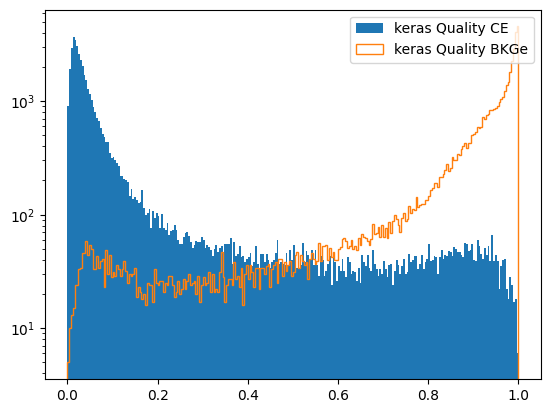

In [5]:
kQpresel = kQ[kQ==-1]
kQpass = kQ[kQ>-1]
print("clusters failed pre sel cuts",len(kQpresel))
print("clusters pass pre sel cuts",len(kQpass))
print("pass ratio", len(kQpass) / len(kQ) )
plt.hist(kQCE,label="keras Quality CE", log=1, bins=250,range=(0,1))
plt.hist(kQbkge,label="keras Quality BKGe",histtype='step', log=1, bins=250,range=(0,1))
plt.legend()
plt.show

In [6]:
clusterrho_sig = []
zmin_sig = []
zmax_sig = []
zgap_sig = []
fp_sig = []
lp_sig = []
pgap_sig = []
nplanes_sig = []
planefraction_sig = []
nhits_sig = []
rmscrho_sig = []
rmsctime_sig = []
        
for i in range(signal_dataset.shape[0]):
    clusterrho_sig.append(signal_dataset[i][0])
    
if usePlaneVar:
    for i in range(signal_dataset.shape[0]):
        fp_sig.append(signal_dataset[i][1])
    
    for i in range(signal_dataset.shape[0]):
        lp_sig.append(signal_dataset[i][2])

    for i in range(signal_dataset.shape[0]):
        pgap_sig.append(signal_dataset[i][3])
else:
    for i in range(signal_dataset.shape[0]):
        zmin_sig.append(signal_dataset[i][1])
    
    for i in range(signal_dataset.shape[0]):
        zmax_sig.append(signal_dataset[i][2])

    for i in range(signal_dataset.shape[0]):
        zgap_sig.append(signal_dataset[i][3])
    
for i in range(signal_dataset.shape[0]):
    nplanes_sig.append(signal_dataset[i][4])

for i in range(signal_dataset.shape[0]):
    planefraction_sig.append(signal_dataset[i][5])

for i in range(signal_dataset.shape[0]):
    nhits_sig.append(signal_dataset[i][6])
    
for i in range(signal_dataset.shape[0]):
    rmscrho_sig.append(signal_dataset[i][7])
    
for i in range(signal_dataset.shape[0]):
    rmsctime_sig.append(signal_dataset[i][8])

In [7]:
clusterrho_back = []
zmin_back = []
zmax_back = []
zgap_back = []
fp_back = []
lp_back = []
pgap_back = []
nplanes_back = []
planefraction_back = []
nhits_back = []
rmscrho_back = []
rmsctime_back = []

for i in range(bkg_dataset.shape[0]):
    clusterrho_back.append(bkg_dataset[i][0])

if usePlaneVar:
    for i in range(bkg_dataset.shape[0]):
        fp_back.append(bkg_dataset[i][1])
    
    for i in range(bkg_dataset.shape[0]):
        lp_back.append(bkg_dataset[i][2])

    for i in range(bkg_dataset.shape[0]):
        pgap_back.append(bkg_dataset[i][3])
else:
    for i in range(bkg_dataset.shape[0]):
        zmin_back.append(bkg_dataset[i][1])
    
    for i in range(bkg_dataset.shape[0]):
        zmax_back.append(bkg_dataset[i][2])

    for i in range(bkg_dataset.shape[0]):
        zgap_back.append(bkg_dataset[i][3])
  
for i in range(bkg_dataset.shape[0]):
    nplanes_back.append(bkg_dataset[i][4])
    
for i in range(bkg_dataset.shape[0]):
    planefraction_back.append(bkg_dataset[i][5])
    
for i in range(bkg_dataset.shape[0]):
    nhits_back.append(bkg_dataset[i][6])
        
for i in range(bkg_dataset.shape[0]):
    rmscrho_back.append(bkg_dataset[i][7]) 
    
for i in range(bkg_dataset.shape[0]):
    rmsctime_back.append(bkg_dataset[i][8])
    
#print(zmin_sig)

<function matplotlib.pyplot.show(close=None, block=None)>

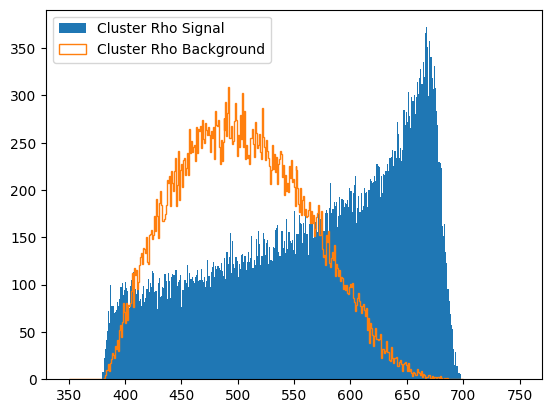

In [8]:
plt.hist(clusterrho_sig,label="Cluster Rho Signal", bins=400,range=(350,750))
plt.hist(clusterrho_back,label="Cluster Rho Background", histtype='step', bins=400,range=(350,700))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

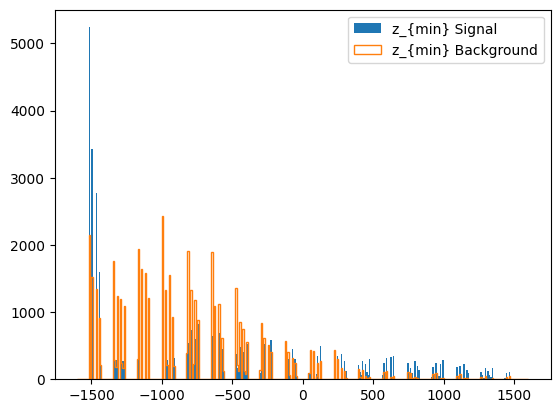

In [9]:
if usePlaneVar:
    plt.hist(fp_sig,label="first plane sig", bins=36, range=(.0,36.0))
    plt.hist(fp_back,label="first plane bkg", histtype='step', bins=36, range=(.0,36.0))
else:
    plt.hist(zmin_sig,label="z_{min} Signal", bins=320,range=(-1600.0,1600.0))
    plt.hist(zmin_back,label="z_{min} Background", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

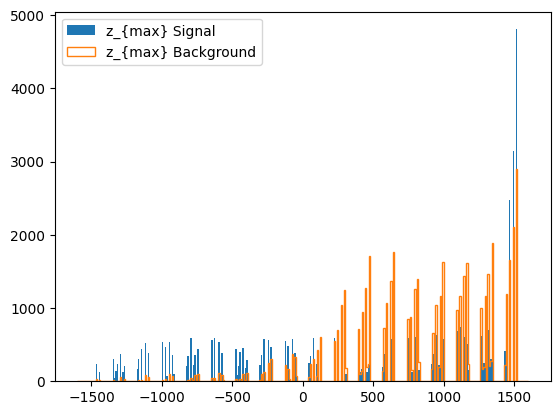

In [10]:
if usePlaneVar:
    plt.hist(lp_sig,label="last plane sig", bins=36, range=(.0,36.0))
    plt.hist(lp_back,label="last plane bkg", histtype='step', bins=36, range=(.0,36.0))
else:
    plt.hist(zmax_sig,label="z_{max} Signal", bins=320,range=(-1600.0,1600.0))
    plt.hist(zmax_back,label="z_{max} Background", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

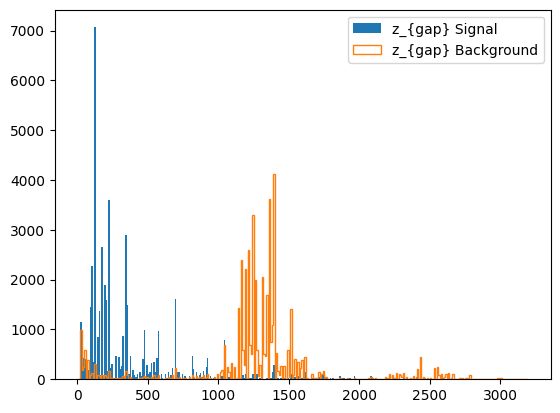

In [11]:
if usePlaneVar:
    plt.hist(pgap_sig,label="plane_{gap} Signal", bins=36,range=(0.0,36.0))
    plt.hist(pgap_back,label="plane_{gap} Background", histtype='step', bins=36, range=(0.0,36.0))
else:
    plt.hist(zgap_sig,label="z_{gap} Signal", bins=320,range=(0.0,3200.0))
    plt.hist(zgap_back,label="z_{gap} Background", histtype='step', bins=320, range=(0.0,3200.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

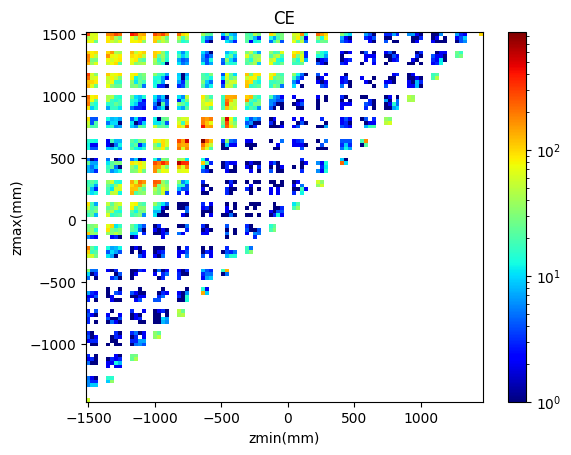

In [12]:
if usePlaneVar:
    plt.hist2d(fp_back,lp_back,bins=(36,36),norm='log',cmap=plt.cm.jet)
    plt.colorbar()
    plt.title('CE')
    plt.xlabel('first plane')
    plt.ylabel('last plane')
else:
    plt.hist2d(zmin_back,zmax_back,bins=(100,100),norm='log',cmap=plt.cm.jet)
    plt.colorbar()
    plt.title('CE')
    plt.xlabel('zmin(mm)')
    plt.ylabel('zmax(mm)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

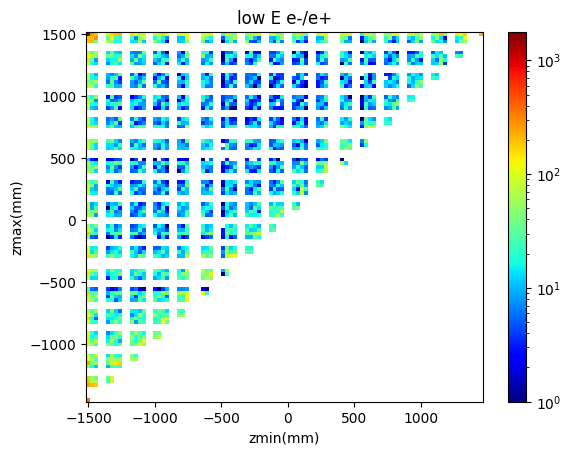

In [13]:
if usePlaneVar:
    plt.hist2d(fp_sig,lp_sig,bins=(36,36),norm='log',cmap=plt.cm.jet)
    plt.colorbar()
    plt.title('low E e-/e+')
    plt.xlabel('first plane')
    plt.ylabel('last plane')
else:
    plt.hist2d(zmin_sig,zmax_sig,bins=(100,100),norm='log',cmap=plt.cm.jet)
    plt.colorbar()
    plt.title('low E e-/e+')
    plt.xlabel('zmin(mm)')
    plt.ylabel('zmax(mm)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

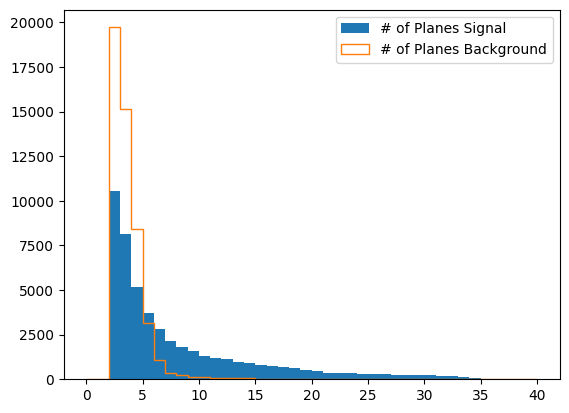

In [14]:
plt.hist(nplanes_sig,label="# of Planes Signal", log=0,bins=40,range=(0,40.0))
plt.hist(nplanes_back,label="# of Planes Background", log=0, histtype='step', bins=40, range=(0,40.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

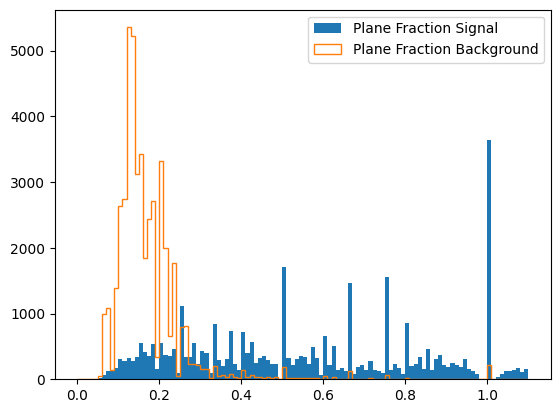

In [15]:
plt.hist(planefraction_sig,label="Plane Fraction Signal", bins=110, range=(0,1.1))
plt.hist(planefraction_back,label="Plane Fraction Background", histtype='step', bins=110, range=(0,1.1))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

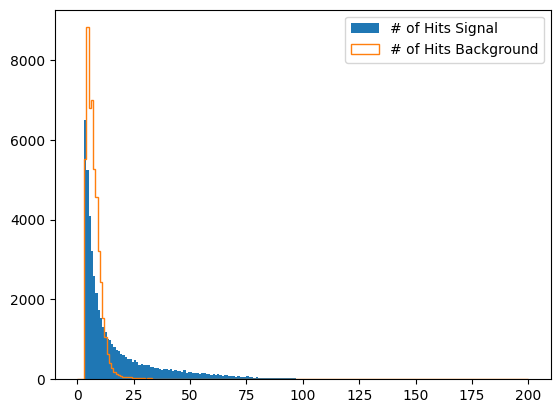

In [16]:
plt.hist(nhits_sig,label="# of Hits Signal", bins=200, range=(0.0,200.0))
plt.hist(nhits_back,label="# of Hits Background", histtype='step', bins=200, range=(0.0,200.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

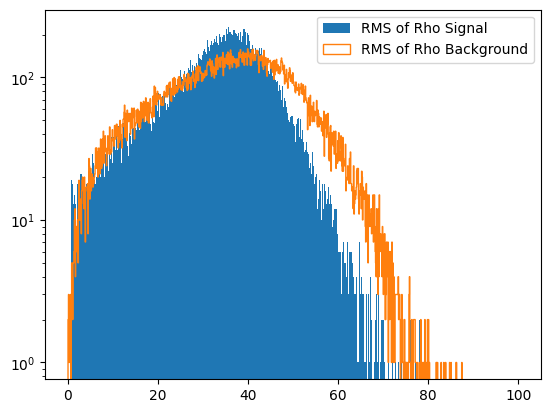

In [17]:
plt.hist(rmscrho_sig,label="RMS of Rho Signal", log=1,bins=1000, range=(0.,100.0))
plt.hist(rmscrho_back,label="RMS of Rho Background",log=1, histtype='step', bins=1000, range=(0.,100.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

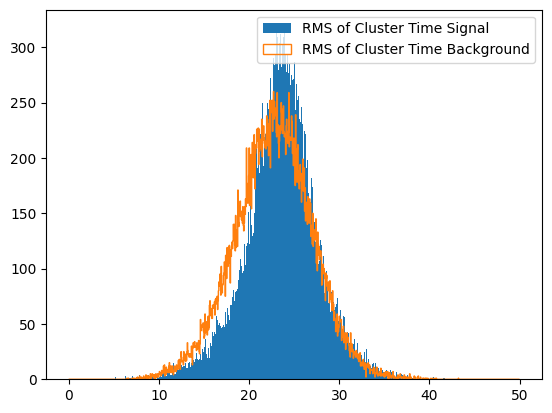

In [18]:
plt.hist(rmsctime_sig,label="RMS of Cluster Time Signal", bins=1000, range=(0.0,50.0))
plt.hist(rmsctime_back,label="RMS of Cluster Time Background",histtype='step', bins=1000, range=(0.0,50.0))
plt.legend()
plt.show

In [19]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(2*n_variables, activation='relu')(lay0)
lay2=Dense(2*n_variables, activation='relu')(lay1)
lay3=Dense(2*n_variables, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(2*n_variables, activation='relu')(input)
x=Dense(2*n_variables, activation='relu')(x)
x=Dense(2*n_variables, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model_ce=Model(inputs=input,outputs=output)
model_ce.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True)
history_ce = model_ce.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop]
                         )

2023-06-20 20:29:17.736865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/TrkAna/lib:/mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/Production/lib:/mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/Offline/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cryptopp/v08_02_00/Linux64bit+3.10-2.17-e20-prof:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib64:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib:/cvmfs/fermilab.opensciencegrid.org/products/common/db/../prd/curl/v7_64_1/Linux64bit-3-10/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cry/v1_7p/Linux64bit+3.10-2.17-e20-prof/cry_v1.7/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/KinKal/v02_03_01b/slf7.x86_64.e20.p3915.prof/li

Epoch 1/200
1526/1526 [==============================] - 5s 2ms/step - loss: 0.9747 - accuracy: 0.8371 - val_loss: 0.4581 - val_accuracy: 0.8829
Epoch 2/200
1526/1526 [==============================] - 3s 2ms/step - loss: 0.4486 - accuracy: 0.8608 - val_loss: 0.4051 - val_accuracy: 0.8573
Epoch 3/200
1526/1526 [==============================] - 3s 2ms/step - loss: 0.3930 - accuracy: 0.8741 - val_loss: 0.3176 - val_accuracy: 0.8887
Epoch 4/200
1526/1526 [==============================] - 3s 2ms/step - loss: 0.3373 - accuracy: 0.8818 - val_loss: 0.3363 - val_accuracy: 0.8778
Epoch 5/200
1526/1526 [==============================] - 3s 2ms/step - loss: 0.3190 - accuracy: 0.8888 - val_loss: 0.2952 - val_accuracy: 0.8963
Epoch 6/200
1526/1526 [==============================] - 3s 2ms/step - loss: 0.3033 - accuracy: 0.8927 - val_loss: 0.2713 - val_accuracy: 0.9021
Epoch 7/200
1526/1526 [==============================] - 3s 2ms/step - loss: 0.2909 - accuracy: 0.8948 - val_loss: 0.2812 - val_ac

In [20]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_ce_train, y_ce_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
#prediction_ce = model_ce.predict(x_ce_test).ravel()
prediction_ce = model_ce.predict(x_ce_test)
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

763/763 [==============================] - 1s 972us/step


In [22]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

(0.0, 1.05)

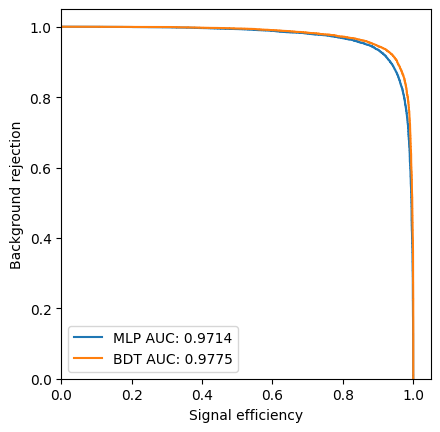

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.4f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.4f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0.,1.05)
ax.set_ylim(0.,1.05)
#fig.savefig("TrainBkgDiag.pdf")

In [70]:
output_model.set_weights(model_ce.get_weights())
output_model.summary()
output_model.save("model/TrainBkgDiag.h5")
#model_ce.save("TrainBkgDiag.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 9)]                  0         
                                                                 
 dense (Dense)               (1, 18)                   180       
                                                                 
 dense_1 (Dense)             (1, 18)                   342       
                                                                 
 dense_2 (Dense)             (1, 18)                   342       
                                                                 
 dense_3 (Dense)             (1, 1)                    19        
                                                                 
Total params: 883
Trainable params: 883
Non-trainable params: 0
_________________________________________________________________
